In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
import numpy as np

%matplotlib inline

In [3]:
# resource configuration
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 300
# fount information
rcParams["font.family"] = "Equinor"
rcParams["font.size"] = 8

# fornt location
font_path = r"Equinor_regular"
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [4]:
# where WellClass and Ga[ codes are located
sys.path.append("../")

In [5]:
# WellClass
# from well_class_v2 import csv_parser, Well
from src.WellClass.libs.utils import csv_parser, yaml_parser

from src.WellClass.libs.well_class import Well
from src.WellClass.libs.well_pressure import Pressure


# plots
from src.WellClass.libs.plotting import plot_pressure, plot_pt, plot_sketch, plot_onepager

## Some user options

In [6]:
# use yaml or csv input file
use_yaml = True

In [7]:
# pick an example from given three options

case_type = "wildcat"

case_type = "smeaheia_v1"

# case_type = 'smeaheia_v2'

In [8]:
# where pvt located
pvt_path = "../src/WellClass/libs/pvt/pvt_constants/pure_co2"

# Examples

The following are the test examples.

In [9]:
# examples
smeaheia_v1 = {
    "well_input": r"GaP_input_Smeaheia_v3.csv",
    "well_input_yaml": r"smeaheia.yaml",
    #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA',
    "sim_path": r"../test_data/examples/smeaheia_v1",
    "simcase": r"GEN_NOLGR_PH2",
}
smeaheia_v2 = {
    "well_input": r"GaP_input_Smeaheia_v3.csv",
    "well_input_yaml": r"smeaheia.yaml",
    #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model',
    "sim_path": r"../test_data/examples/smeaheia_v2",
    "simcase": r"TEMP-0",
}
wildcat = {
    "well_input": r"GaP_input_Wildcat_v3.csv",
    "well_input_yaml": r"wildcat.yaml",
    #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model',
    "sim_path": r"../test_data/examples/wildcat",
    "simcase": r"TEMP-0",
}

In [10]:
examples = {"smeaheia_v1": smeaheia_v1, "smeaheia_v2": smeaheia_v2, "wildcat": wildcat}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [11]:
# the selected example for testing
case = examples[case_type]


In [12]:
# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

sim_path = case["sim_path"]


In [13]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case["well_input_yaml"])

    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case["well_input"])

    # load the well information
    well_csv = csv_parser(well_name)

In [14]:
# Process well by running well class
my_well = Well(
    header=well_csv["well_header"],
    drilling=well_csv["drilling"],
    casings=well_csv["casing_cement"],
    geology=well_csv["geology"],
    barriers=well_csv["barriers"],
    barrier_perm=well_csv["barrier_permeability"],
    co2_datum=well_csv["co2_datum"],
)

## Generation of Pressure tables
### 1. Minimum input: 

The pressure class can be initialized with a minimum of the following parameters:
- Depth to seabed in mTVDMSL
- Wellbore TD in mRKB
- Wellbore RKB in mTVDMSL
- Seafloor temperature in degC. Defaulted to 4 degC
- Geothermal gradient in degC/km. Defaulted to 40 degC/km
- Fluid type: This depends on the PVT tables available on pvtpath 
  - pure CO2, Components: 100% CO2
  - pure C1, Components: 100% CH4
  - mixture 1, Components: 96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4
  - mixture 2, Components: 95% CO2, 5% CH4
- Path to the PVT tables


If depth of fluid contact is provided, by default Pressure class will calculate a pressure scenario with a hydrosatic gradient from the fluid contact to the surface

In [15]:
my_pressure = Pressure(
    sf_depth_msl=well_csv["well_header"]["sf_depth_msl"],
    well_td_rkb=well_csv["well_header"]["well_td_rkb"],
    well_rkb=well_csv["well_header"]["well_rkb"],
    sf_temp=well_csv["well_header"]["sf_temp"],
    geo_tgrad=well_csv["well_header"]["geo_tgrad"],
    fluid_type="pure_co2",
    z_fluid_contact=well_csv["co2_datum"],
    pvt_path="../src/WellClass/libs/pvt/pvt_constants",
)

Computing pressure profile for scenario: hydrostatic


In [16]:
my_pressure.scenario_manager.get_scenarios_summary()

,name,from_resrvr,z_MSAD,p_MSAD,z_MSAD_brine,p_MSAD_brine,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,hydrostatic,True,551.869766,73.08267,None,None,1282.5,129.994025,1282.5,129.994025,0.0,pure_co2,100% CO2,None


If other fluid compostions want to be added and compared, the user can pick between pure CO2, mixture1, mixture2 or pure methane, or provide its own specific gravity

In [17]:
my_pressure = Pressure(
    sf_depth_msl=well_csv["well_header"]["sf_depth_msl"],
    well_td_rkb=well_csv["well_header"]["well_td_rkb"],
    well_rkb=well_csv["well_header"]["well_rkb"],
    sf_temp=well_csv["well_header"]["sf_temp"],
    geo_tgrad=well_csv["well_header"]["geo_tgrad"],
    fluid_type="pure_co2",
    pvt_path="../src/WellClass/libs/pvt/pvt_constants",
)

fluid_contact = well_csv["co2_datum"]
my_pressure.add_scenario(scenario_name="mixture1", fluid_type="mixture1", from_resrvr=True, z_fluid_contact=fluid_contact)
my_pressure.add_scenario(scenario_name="methane", fluid_type="methane", from_resrvr=True, z_fluid_contact=fluid_contact)
my_pressure.add_scenario(scenario_name="sg_input", from_resrvr=True, specific_gravity=300 / 1e3, z_fluid_contact=fluid_contact)

my_pressure.scenario_manager.get_scenarios_summary()

Computing pressure profile for scenario: mixture1
Computing pressure profile for scenario: methane
Computing pressure profile for scenario: sg_input


,name,from_resrvr,z_MSAD,p_MSAD,z_MSAD_brine,p_MSAD_brine,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,mixture1,True,655.052086,90.572073,None,None,1282.5,129.994025,1282.5,129.994025,0.0,mixture1,"96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4",NaN
1,methane,True,864.783811,126.121600,None,None,1282.5,129.994025,1282.5,129.994025,0.0,methane,100% CH4,NaN
2,sg_input,True,804.698415,115.937126,None,None,1282.5,129.994025,1282.5,129.994025,0.0,None,None,0.3


If simple input scenarios are provided in the input_scenarios argument, these will be computed

In [18]:
my_pressure = Pressure(
    sf_depth_msl=well_csv["well_header"]["sf_depth_msl"],
    well_td_rkb=well_csv["well_header"]["well_td_rkb"],
    well_rkb=well_csv["well_header"]["well_rkb"],
    sf_temp=well_csv["well_header"]["sf_temp"],
    geo_tgrad=well_csv["well_header"]["geo_tgrad"],
    fluid_type="pure_co2",
    input_scenarios=well_csv["reservoir_pressure"],
    z_fluid_contact=well_csv["co2_datum"],
    pvt_path="../src/WellClass/libs/pvt/pvt_constants",
)

my_pressure.scenario_manager.get_scenarios_summary()

scenario_pressure=None
scenario_name='RP1' scenario_pressure=None
Computing pressure profile for scenario: RP1
scenario_pressure='91'
scenario_name='RP2' scenario_pressure='91'
Computing pressure profile for scenario: RP2
scenario_pressure='20'
scenario_name='RP3' scenario_pressure='20'
Computing pressure profile for scenario: RP3


,name,from_resrvr,z_MSAD,p_MSAD,z_MSAD_brine,p_MSAD_brine,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,RP1,True,551.869766,73.082670,NaN,NaN,1282.500000,129.994025,1282.500000,129.994025,0.000000,pure_co2,100% CO2,None
1,RP2,True,1554.826006,243.083752,1554.826004,243.083752,1554.826006,243.083752,1554.826006,243.083752,85.882036,pure_co2,100% CO2,None
2,RP3,True,763.888802,109.019896,601.975187,81.575539,1282.500000,149.994025,1282.500000,149.994025,20.000000,pure_co2,100% CO2,None


### 2. Create a pressure scenario

Create a pressure scenario providing only the **MSAD** (the `from_resrv` flag has to be False )

In [19]:
my_pressure = Pressure(
    sf_depth_msl=well_csv["well_header"]["sf_depth_msl"],
    well_td_rkb=well_csv["well_header"]["well_td_rkb"],
    well_rkb=well_csv["well_header"]["well_rkb"],
    sf_temp=well_csv["well_header"]["sf_temp"],
    geo_tgrad=well_csv["well_header"]["geo_tgrad"],
    fluid_type="pure_co2",
    default_hs_scenario=False,
    #    z_fluid_contact=1300,
    pvt_path="../src/WellClass/libs/pvt/pvt_constants",
)

my_pressure.add_scenario(scenario_name="plug", from_resrvr=False, z_MSAD=500, z_fluid_contact=1300)


Computing pressure profile for scenario: plug


In [20]:
my_pressure.scenario_manager.get_scenarios_summary()

,name,from_resrvr,z_MSAD,p_MSAD,z_MSAD_brine,p_MSAD_brine,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,plug,False,500,64.290745,None,None,1300,126.147521,1300,126.147521,-5.597999,pure_co2,100% CO2,None


Create a pressure scenario providing only the **delta Pressure +/-** and depth **fluid_contact**. The code assumes the reservoir depth is the same as the `co2_datum` (the `from_resrv` flag has to be True )

In [21]:
my_pressure = Pressure(
    sf_depth_msl=well_csv["well_header"]["sf_depth_msl"],
    well_td_rkb=well_csv["well_header"]["well_td_rkb"],
    well_rkb=well_csv["well_header"]["well_rkb"],
    sf_temp=well_csv["well_header"]["sf_temp"],
    geo_tgrad=well_csv["well_header"]["geo_tgrad"],
    fluid_type="pure_co2",
    default_hs_scenario=False,
    #    z_fluid_contact=1300,
    pvt_path="../src/WellClass/libs/pvt/pvt_constants",
    #   shmin_gradient=0.1855
)

my_pressure.add_scenario(scenario_name="test1", from_resrvr=True, p_delta=25, z_fluid_contact=my_well.co2_datum)

my_pressure.scenario_manager.get_scenarios_summary()

Computing pressure profile for scenario: test1


,name,from_resrvr,z_MSAD,p_MSAD,z_MSAD_brine,p_MSAD_brine,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,test1,True,818.026521,118.19624,674.551502,93.877224,1282.5,154.994025,1282.5,154.994025,25,pure_co2,100% CO2,None


In [22]:
my_pressure = Pressure(
    sf_depth_msl=well_csv["well_header"]["sf_depth_msl"],
    well_td_rkb=well_csv["well_header"]["well_td_rkb"],
    well_rkb=well_csv["well_header"]["well_rkb"],
    sf_temp=well_csv["well_header"]["sf_temp"],
    geo_tgrad=well_csv["well_header"]["geo_tgrad"],
    fluid_type="pure_co2",
    default_hs_scenario=False,
    #    z_fluid_contact=1300,
    pvt_path="../src/WellClass/libs/pvt/pvt_constants",
    shmin_gradient=0.1855,
)

my_pressure.add_scenario(scenario_name="test1", from_resrvr=True, p_delta=25, z_fluid_contact=my_well.co2_datum)

my_pressure.scenario_manager.get_scenarios_summary()

Computing pressure profile for scenario: test1


,name,from_resrvr,z_MSAD,p_MSAD,z_MSAD_brine,p_MSAD_brine,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,test1,True,738.341639,111.511119,606.057428,86.972398,1282.5,154.994025,1282.5,154.994025,25,pure_co2,100% CO2,None


Create a pressure scenario providing only the **delta Pressure +/-** at reservoir and the reservoir depth (the `from_resrv` flag has to be True )

In [23]:
my_pressure.add_scenario(scenario_name="test2", from_resrvr=True, p_delta=10, z_resrv=1180, z_fluid_contact=my_well.co2_datum)

my_pressure.scenario_manager.get_scenarios_summary()

Computing pressure profile for scenario: test2


,name,from_resrvr,z_MSAD,p_MSAD,z_MSAD_brine,p_MSAD_brine,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,test1,True,738.341639,111.511119,606.057428,86.972398,1282.5,154.994025,1282.5,154.994025,25,pure_co2,100% CO2,None
1,test2,True,601.949587,86.210393,429.512195,54.223257,1180.0,132.459454,1282.5,139.994025,10,pure_co2,100% CO2,None


Create a pressure scenario providing a pressure measurement (value) and its correspoinding depth (the `from_resrv` flag has to be True )

In [24]:
my_pressure.add_scenario(scenario_name="test3", from_resrvr=True, z_resrv=1100, p_resrv=200)

my_pressure.scenario_manager.get_scenarios_summary()


Computing pressure profile for scenario: test3


,name,from_resrvr,z_MSAD,p_MSAD,z_MSAD_brine,p_MSAD_brine,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,test1,True,738.341639,111.511119,606.057428,86.972398,1282.500000,154.994025,1282.500000,154.994025,25.000000,pure_co2,100% CO2,None
1,test2,True,601.949587,86.210393,429.512195,54.223257,1180.000000,132.459454,1282.500000,139.994025,10.000000,pure_co2,100% CO2,None
2,test3,True,1309.377701,217.438308,1309.377700,217.438308,1309.377701,217.438308,1309.377701,217.438308,84.754383,pure_co2,100% CO2,None


In [25]:
my_pressure.scenario_manager.scenarios["test3"].init_curves

,depth,temperature,hydrostatic_pressure,min_horizontal_stress,fluid_pressure,brine_pressure
0.0,0.0,4.00,1.013250,1.013250,NaN,NaN
1.0,1.0,4.00,1.113844,1.113844,NaN,NaN
2.0,2.0,4.00,1.214438,1.214438,NaN,NaN
3.0,3.0,4.00,1.315033,1.315033,NaN,NaN
4.0,4.0,4.00,1.415628,1.415628,NaN,NaN
...,...,...,...,...,...,...
3657.0,3657.0,137.80,362.426030,652.922245,NaN,447.991288
3658.0,3658.0,137.84,362.521160,653.107745,NaN,448.086595
3659.0,3659.0,137.88,362.616288,653.293245,NaN,448.181899
3660.0,3660.0,137.92,362.711412,653.478745,NaN,448.277199


# Visualization

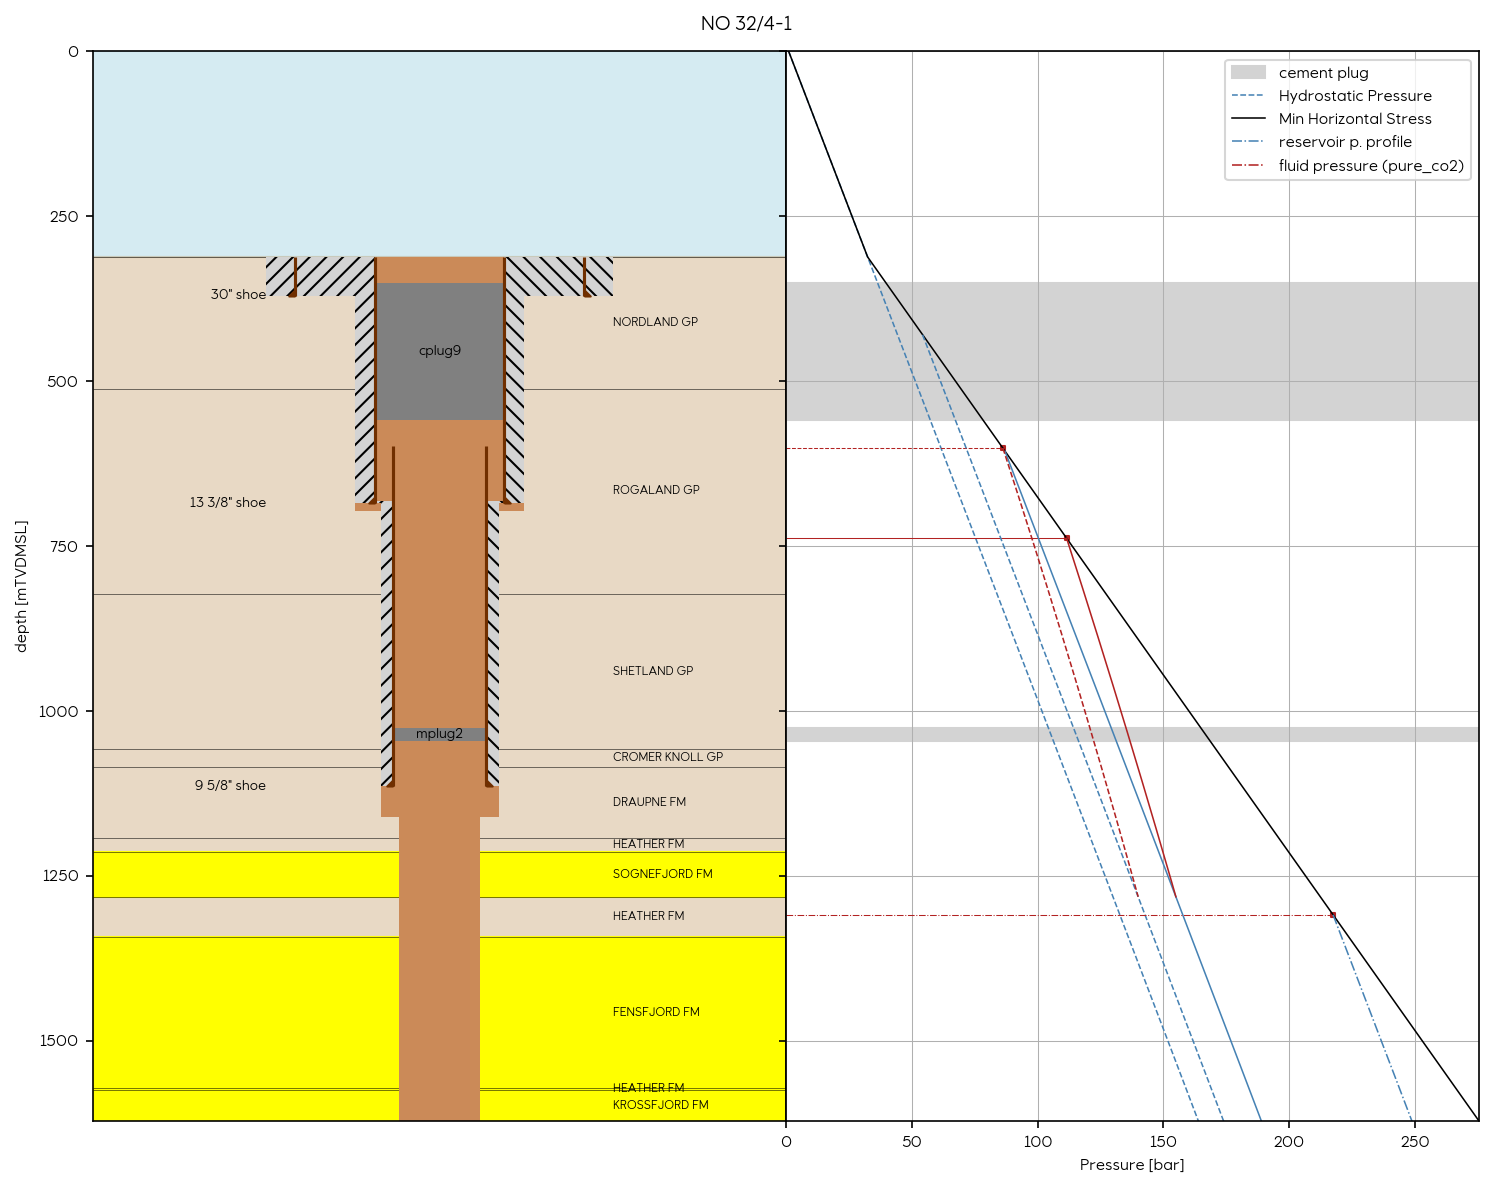

In [26]:
fig, axs = plot_onepager(my_well, my_pressure, pressure_MSAD=True, pressure_HSP=True)


In [27]:
rcParams["font.size"]

8.0

# CO2 Leakage

In [28]:
# pick one barrier
main_barrier = well_csv["main_barrier"]
main_barrier

'cplug9'

In [29]:
my_well.barrier_perm

{'quality': ['good', 'mid', 'poor'], 'kv': [0.01, 10, 1000.0]}

In [30]:
my_pressure.compute_barrier_leakage(well=my_well, barrier_name=main_barrier)

,p_brine_above_barrier,p_fluid_below_barrier,rho_brine_below_barrier,rho_fluid_below_barrier,0.01,10,1000.0
test1,36.403755,NaN,1027.395455,NaN,NaN,NaN,NaN
test2,36.403755,NaN,1027.395455,NaN,NaN,NaN,NaN
test3,36.403755,NaN,1027.395455,NaN,NaN,NaN,NaN
